It has become fairly clear that I should at least look into labeling the ground truth a different way. With other maps, I can see that some observations aren't labeled as forest-fires that probably should be, or at least from a business/real-world perspective. I can see that some observations aren't labeled as forest-fires because they don't fall within a fire-perimeter boundary on that given day, but they do fall within a fire-perimeter boundary days later. In terms of training a model, I think it's reasonable that we should train it to identify these observations as forest fires. Given that they do fall within a fire-perimter boundary within a couple of days, it's highly likely that they were forest-fire observations, and either fire-perimeter boundaries weren't submitted for that day for that area, or the fire wasn't seen (meaning no perimeter boundary drawn around it). In either case, I think it's reasonable to label these as forest-fires and see. 

In this notebook, I'll be exploring what I label as forest-fires/non-forest-fires if I go out 0, 1, 3, 5, and 7 days ahead to look for fire perimeter boundaries that an ob. falls in. I'll first look at some maps to check and see whether it looks like the new version of the PostgreSQL merging to labele forest-fires worked correctly. After that, I'll compare the distributions of variables for fires/non-fires based on how far ahead I look to label the fires. 

In [2]:
import pandas as pd
from dsfuncs.geo_plotting import USMapBuilder
import matplotlib.pyplot as plt
import fiona
import subprocess
import datetime
%matplotlib inline

In [3]:
def read_df(year, days_ahead): 
    """This function will read in a year of data, and add a month column. 
    
    Args: 
        year: str
        modis: bool
            Whether to use the modis or viirs data for plotting. 
        
    Return:
        Pandas DataFrame
    """
    print days_ahead
    output_df = pd.read_csv('../../../data/csvs/day{}/detected_fires_MODIS_'.format(days_ahead) + str(year) + '.csv', 
            parse_dates=['date'], true_values=['t'], false_values=['f'])
    output_df['month'] = output_df.date.apply(lambda dt: dt.strftime('%B'))
    output_df.dropna(subset=['region_name'], inplace=True) # These will be obs. in Canada. 
    return output_df
    
def grab_by_location(df, state_names, county_names=None): 
    """Grab the data for a specified inputted state and county. 
    
    Args: 
        df: Pandas DataFrame
        state: set (or iterable of strings)
            State to grab for plotting.
        county: set (or iterable of strings) (optional)
            County names to grab for plotting. If None, simply grab the 
            entire state to plot. 
            
    Return: 
        Pandas DataFrame
    """
    if county_names: 
        output_df = df.query('state_name in @state_names and county_name in @county_names')
    else: 
        output_df = df.query('state_name in @state_names')
    return output_df

def grab_by_date(df, months=None, dt=None): 
    """Grab the data for a set of specified months.
    
    Args: 
        df: Pandas DataFrame
        months: set (or iterable of strings)
    
    Return: 
        Pandas DataFrame
    """
    if months is not None: 
        output_df = df.query("month in @months")
    else: 
        split_dt = dt.split('-')
        year, month, dt = int(split_dt[0]), int(split_dt[1]), int(split_dt[2])
        match_dt = datetime.datetime(year, month, dt, 0, 0, 0)
        output_df = df.query('date == @match_dt')
    return output_df

def format_df(df): 
    """Format the data to plot it on maps. 
    
    This function will grab the latitude and longitude 
    columns of the DataFrame, and return those, along 
    with a third column that will be newly generated. This 
    new column will hold what color we want to use to plot 
    the lat/long coordinate - I'll use red for fire and 
    green for non-fire. 
    
    Args: 
        df: Pandas DataFrame
    
    Return: 
        numpy.ndarray
    """
    
    keep_cols = ['long', 'lat', 'fire_bool']
    intermediate_df = df[keep_cols]
    output_df = parse_fire_bool(intermediate_df)
    output_array = output_df.values
    return output_array

def parse_fire_bool(df): 
    """Parse the fire boolean to a color for plotting. 
    
    Args: 
        df: Pandas DataFrame
        
    Return: 
        Pandas DataFrame
    """
    
    # Plot actual fires red and non-fires green. 
    output_df = df.drop('fire_bool', axis=1)
    print df.fire_bool.mean()
    output_df['plotting_mark'] = df['fire_bool'].apply(lambda f_bool: 'ro' if f_bool == True else 'go')
    return output_df

def read_n_parse(year, state_names, county_names=None, months=None, plotting=False, dt=None, days_ahead=0): 
    """Read and parse the data for plotting.
    
    Args: 
        year: str
        state_names: set (or other iterable) of state names
            State names to grab for plotting. 
        county_names: set (or other iterable) of county names (optional)
            County names to grab for plotting. 
        months: months (or other iterable) of months (optional)
            Month names to grab for plotting. 
        plotting: bool 
            Whether or not to format the data for plotting. 
            
    Return: 
        Pandas DataFrame
    """
    
    fires_df = read_df(year, days_ahead)
    if state_names: 
        fires_df = grab_by_location(fires_df, state_names, county_names)
    
    if months or dt: 
        fires_df = grab_by_date(fires_df, months, dt)
    
    if plotting: 
        fires_df = format_df(fires_df)
    return fires_df

def grab_fire_perimeters(dt, st_name, st_abbrev, st_fips, county=False): 
    """Grab the fire perimter boundaries for a given state and year.
    
    Args: 
        dt: str
        st_name: str
            State name of boundaries to grab. 
        st_abbrev: str
            State abbreviation used for bash script. 
        st_fips: str
            State fips used for bash script. 
            
    Return: Shapefile features. 
    """
            
    # Run bash script to pull the right boundaries from Postgres. 
    subprocess.call("./grab_perim_boundary.sh {} {} {}".format(st_abbrev, st_fips, dt), shell=True)
    
    filepath = 'data/{}/{}_{}_2D'.format(st_abbrev, st_abbrev, dt)
    return filepath

def plot_county_dt(st_name, st_abbrev, st_fips, county_name, fires_dt=None, perims_dt=None, 
                  days_ahead=0): 
    """Plot all obs., along with the fire-perimeter boundaries, for a given county and date. 
    
    Read in the data for the inputted year and parse it to the given state/county and date. 
    Read in the fire perimeter boundaries for the given state/county and date, and parse 
    those. Plot it all. 
    
    Args: 
        st_name: str
            State name to grab for plotting. 
        st_abbrev: str
            State abbrevation used for the bash script. 
        st_fips: str
            State fips used for the base script. 
        county_name: str
            County name to grab for plotting. 
        dt: str
            Date to grab for plotting. 
    """
    
    year = fires_dt.split('-')[0]
    perims_dt = fires_dt if not perims_dt else perims_dt
    county_names = [county_name] if not isinstance(county_name, list) else county_name
    fires_data = read_n_parse(year, state_names=st_name, county_names=county_name, dt=fires_dt, plotting=True,
                             days_ahead=days_ahead)
    county_map = USMapBuilder('data/county_shapefiles_2014/cb_2014.shp', geo_level='County', 
                state_names=[st_name], county_names=county_names, figsize=(40, 20), border_padding=0.1)
    fire_boundaries = grab_fire_perimeters(perims_dt, st_name, st_abbrev, st_fips)
    try: 
        county_map.plot_boundary(fire_boundaries)
    except Exception as e:
        print e
    county_map.plot_points(fires_data, 4)
    plt.show()

Date: 2015-08-01
--------------------------------------------------
0
0.362068965517


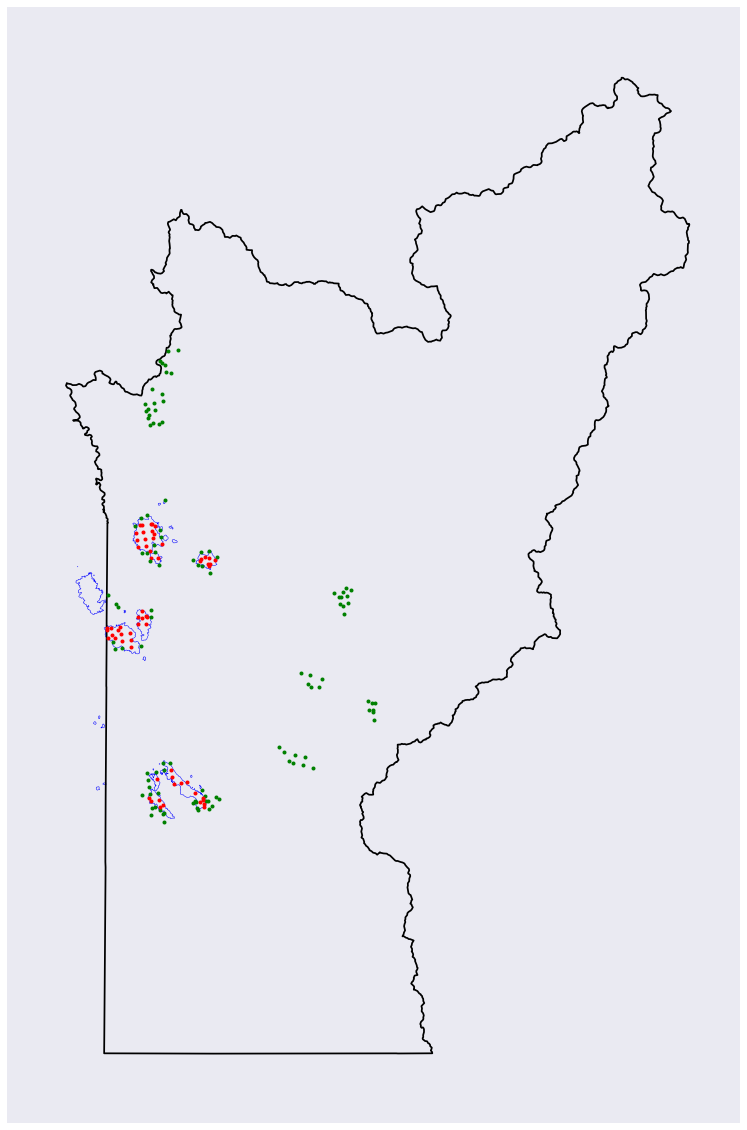

Date: 2015-08-02
--------------------------------------------------
0
0.433962264151


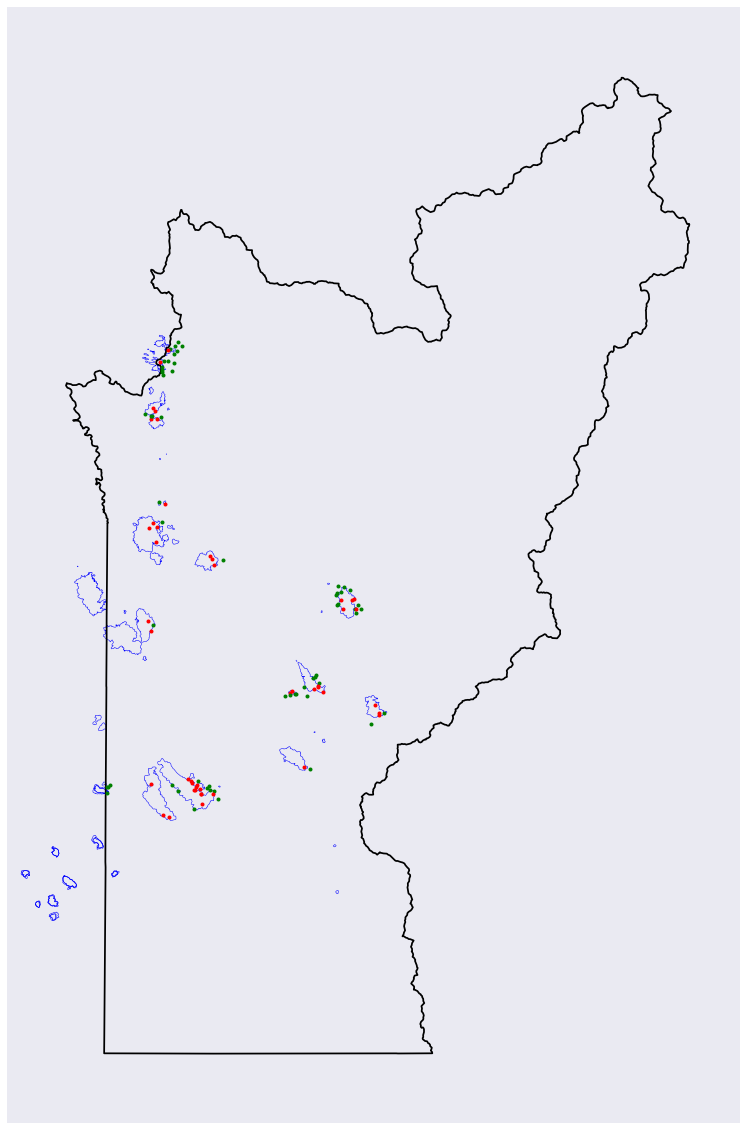

Date: 2015-08-03
--------------------------------------------------
0
0.333333333333


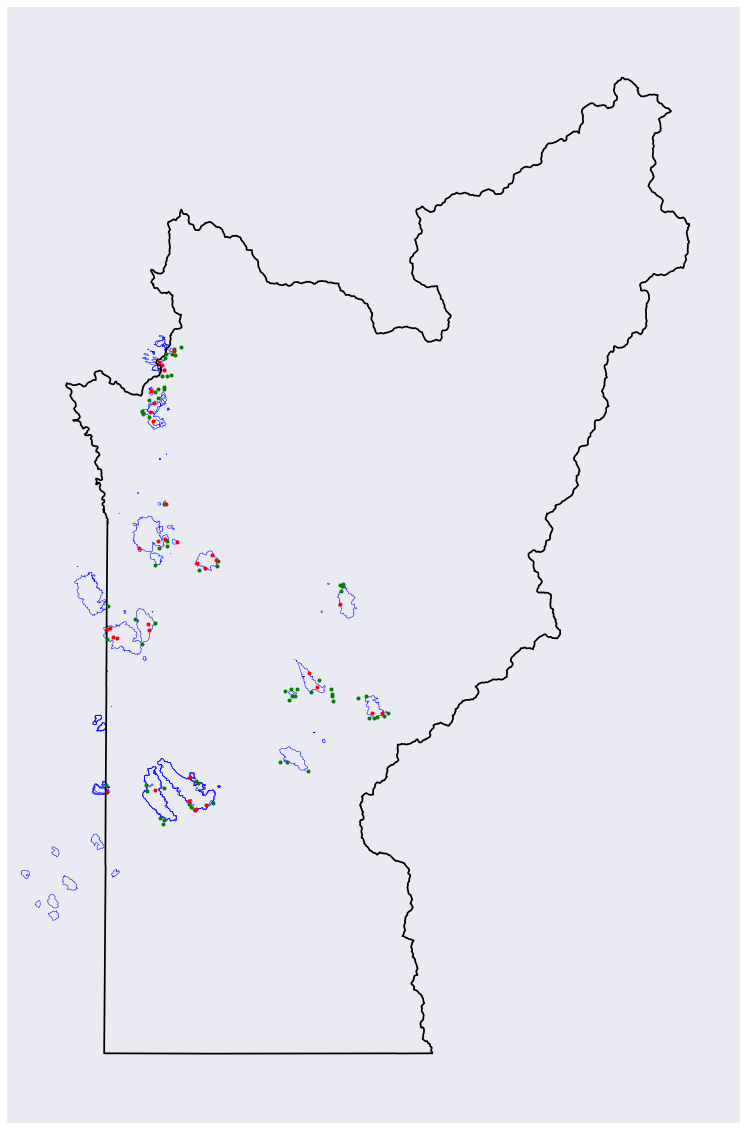

Date: 2015-08-04
--------------------------------------------------
0
0.521739130435


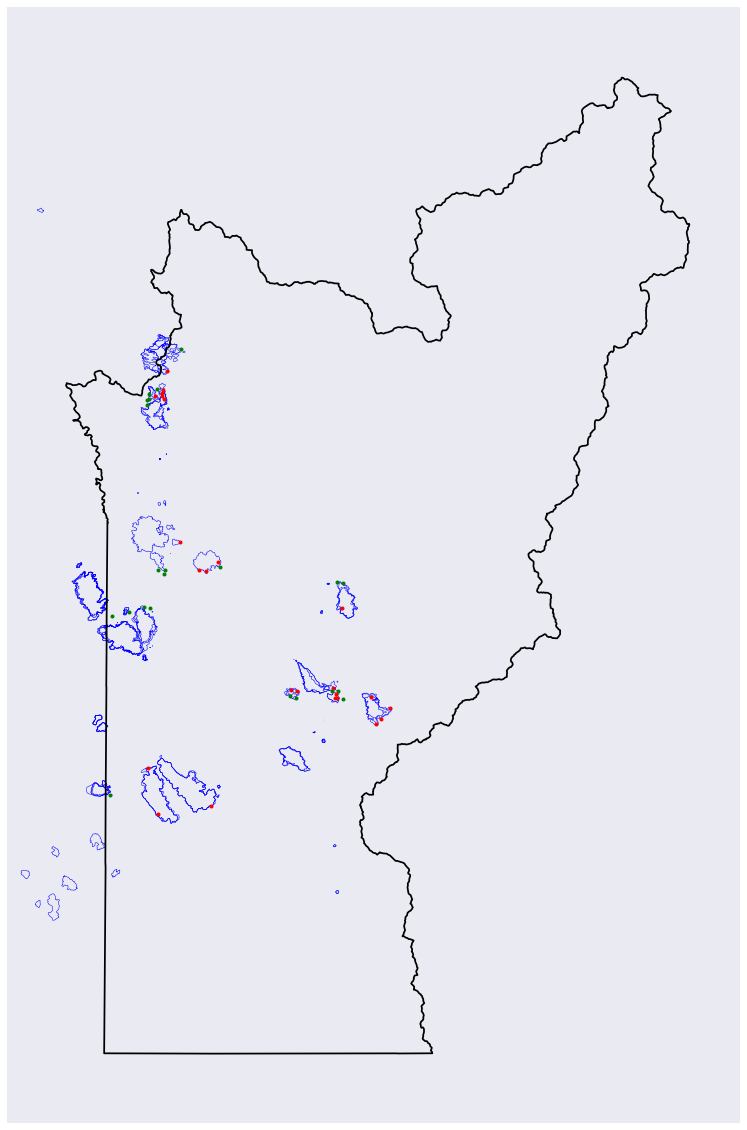

Date: 2015-08-05
--------------------------------------------------
0
0.537878787879


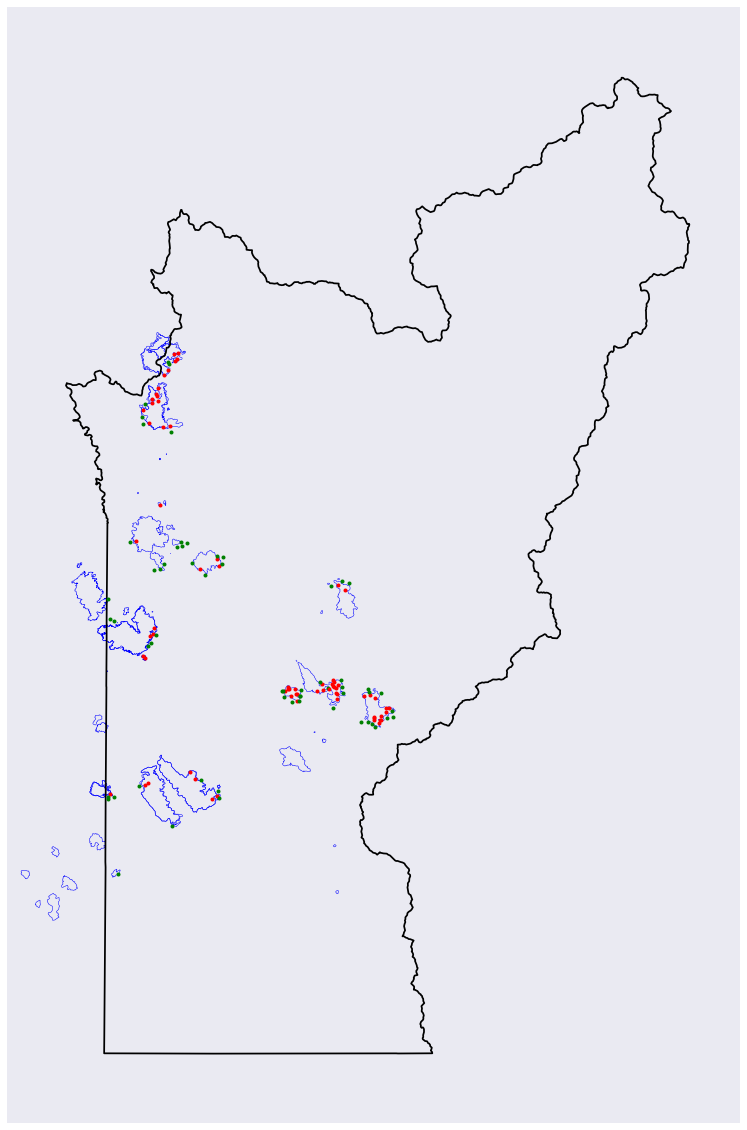

Date: 2015-08-06
--------------------------------------------------
0
0.567567567568


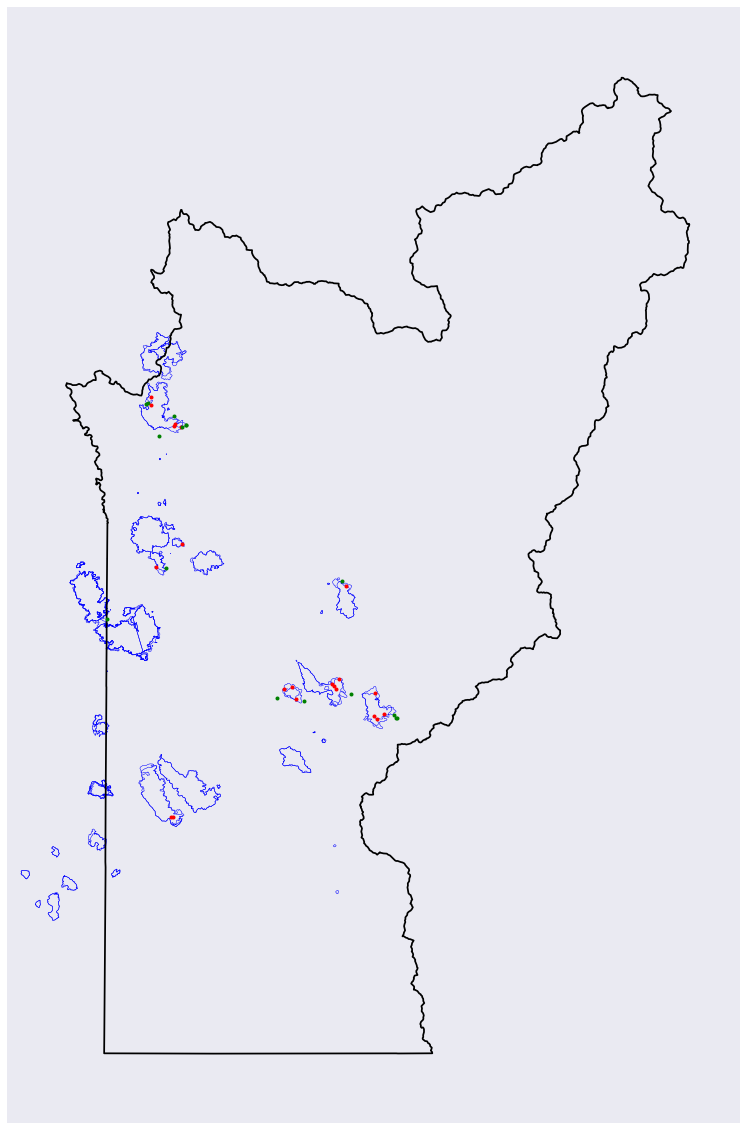

Date: 2015-08-07
--------------------------------------------------
0
0.605769230769


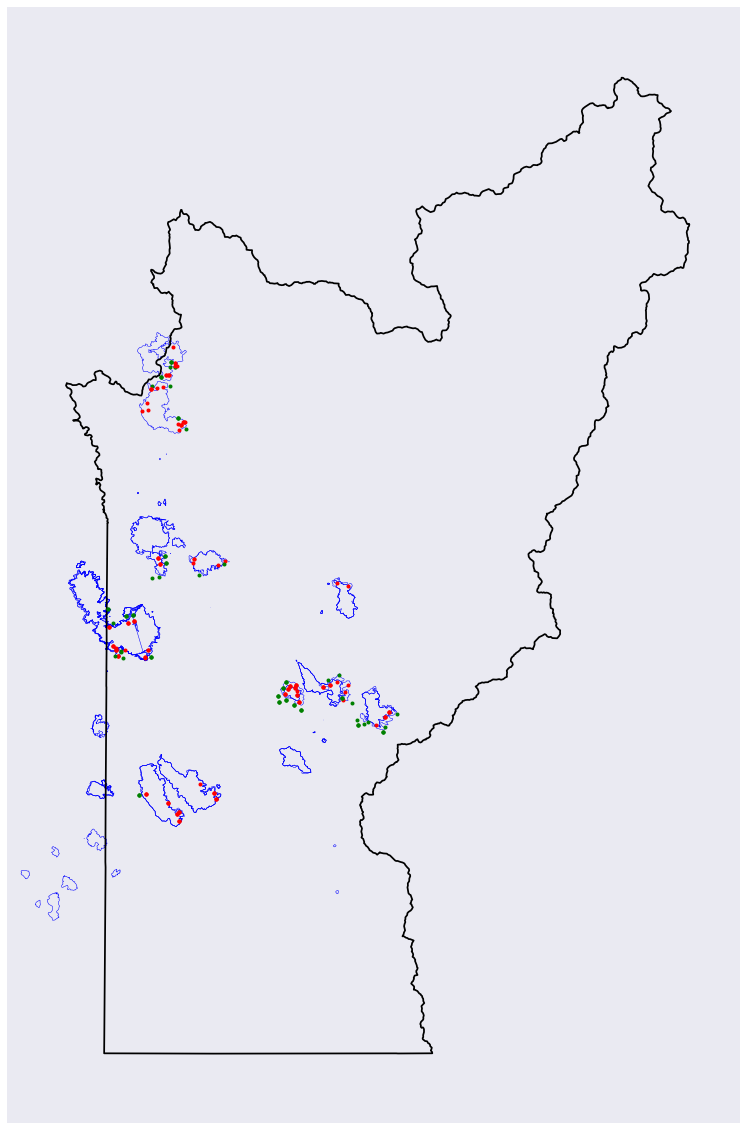

Date: 2015-08-08
--------------------------------------------------
0
0.195652173913


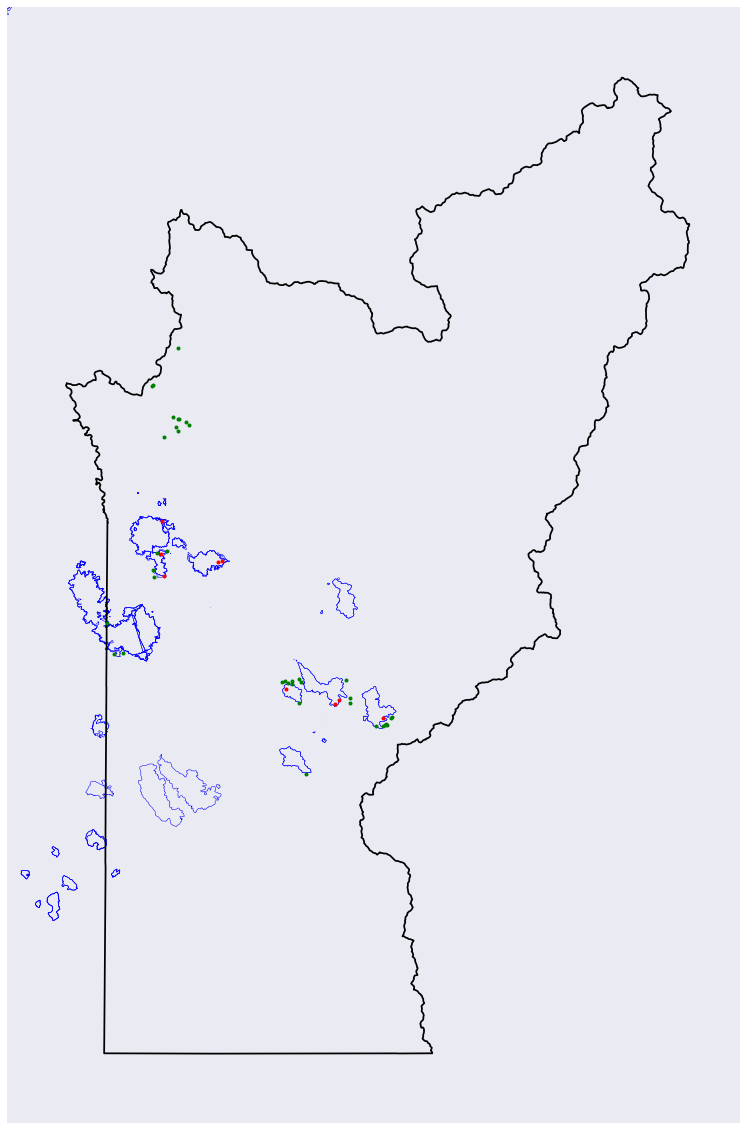

In [7]:
for dt in xrange(1, 9): 
    dt = '2015-08-0' + str(dt) if dt < 10 else '2015-08-' + str(dt)
    print 'Date: {}'.format(dt)
    print '-' * 50
    plot_county_dt('California', 'ca', '06', 'Trinity', dt, days_ahead=0)

Days Ahead: 0
--------------------------------------------------
2015-08-01
0
0.362068965517


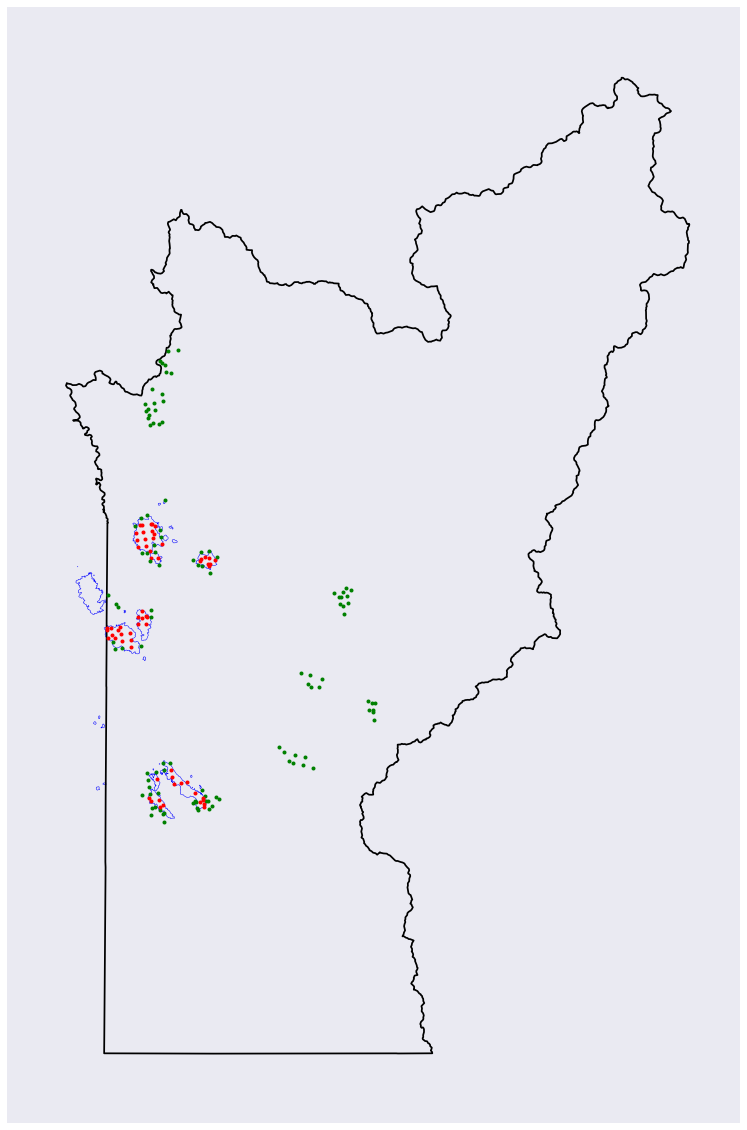

Days Ahead: 1
--------------------------------------------------
2015-08-02
1
0.471264367816


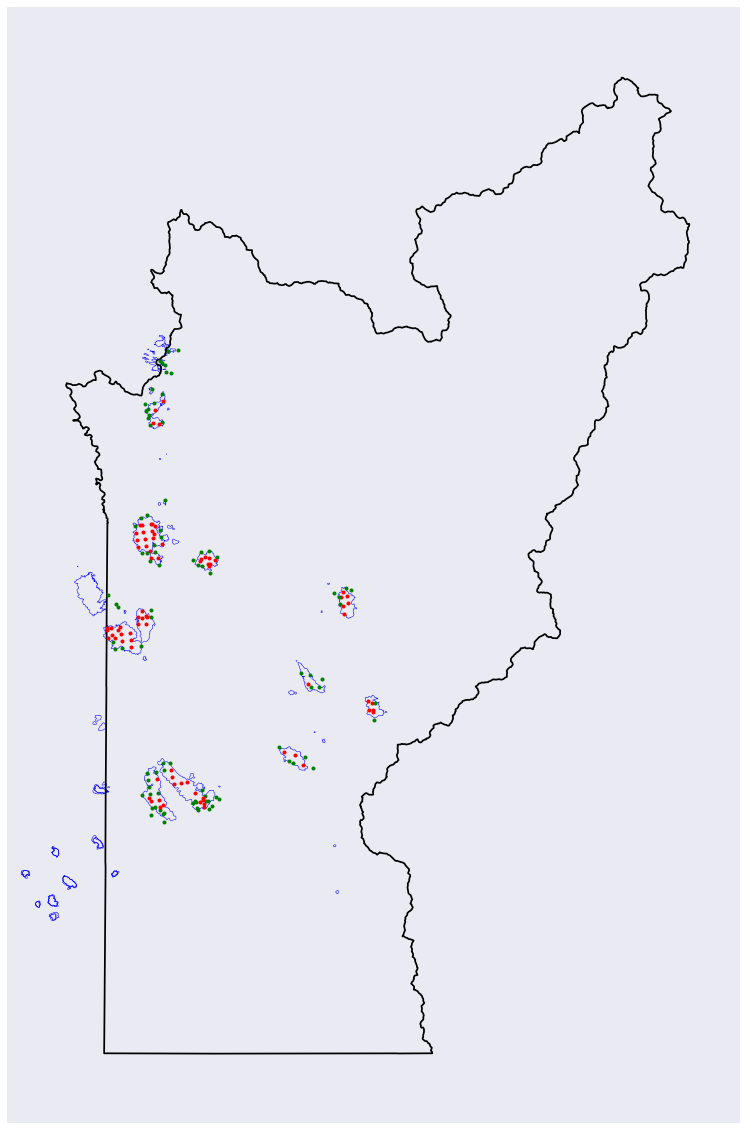

Days Ahead: 3
--------------------------------------------------
2015-08-04
3
0.471264367816


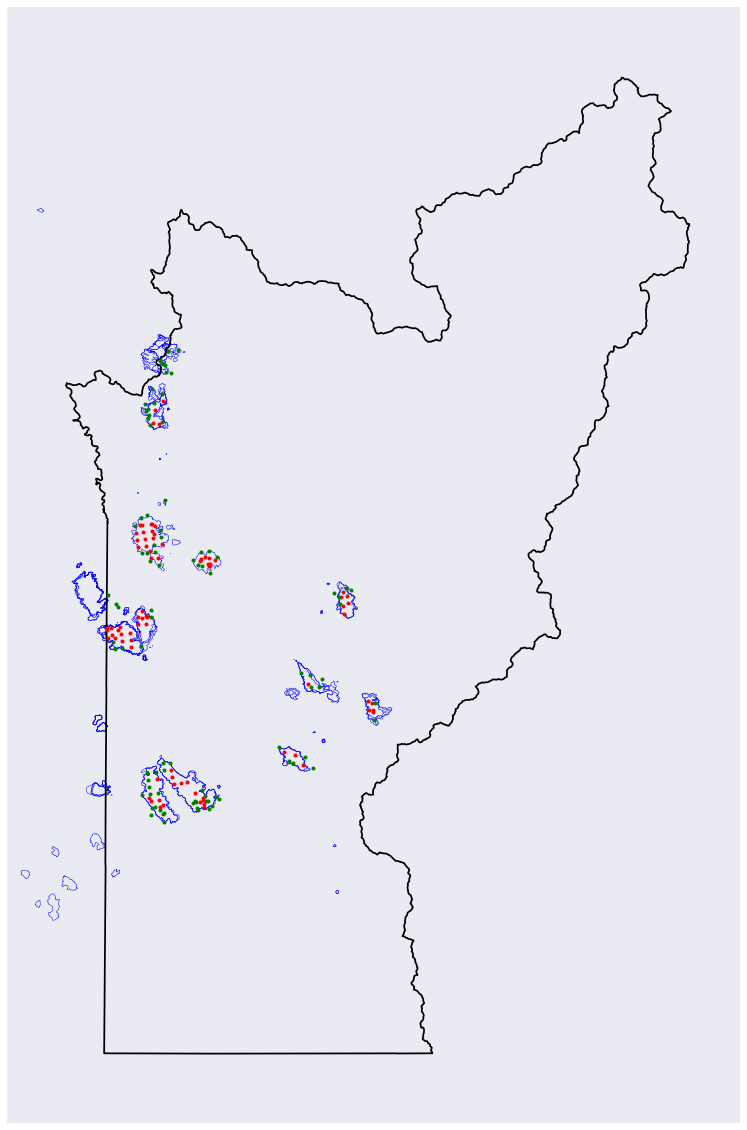

Days Ahead: 5
--------------------------------------------------
2015-08-06
5
0.471264367816


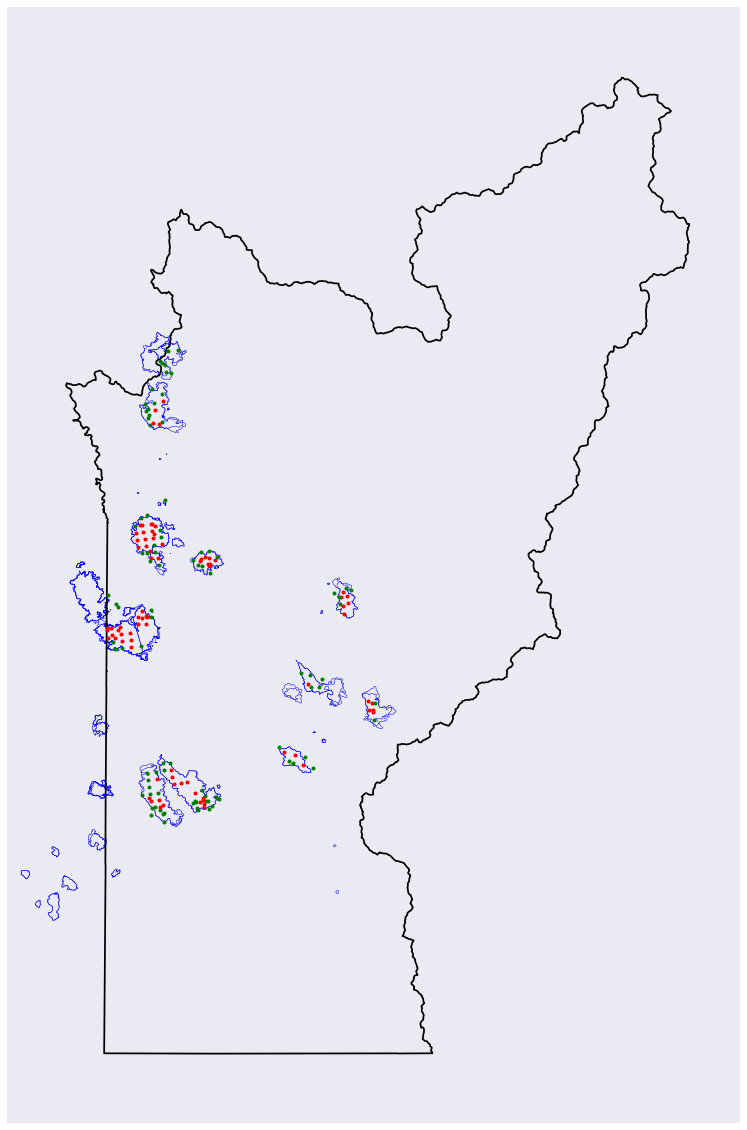

Days Ahead: 7
--------------------------------------------------
2015-08-08
7
0.471264367816


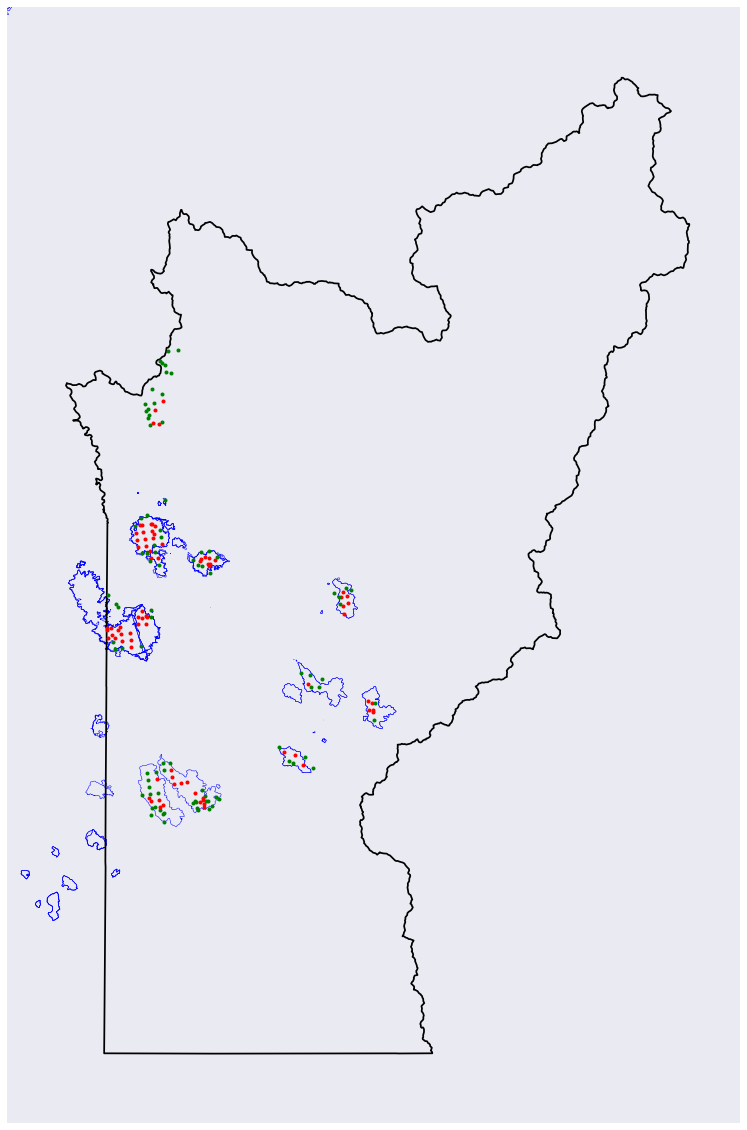

In [16]:
for days_ahead in (0, 1, 3, 5, 7): 
    dt = '2015-08-0' + str(days_ahead + 1) if days_ahead < 10 else '2015-08-' + str(days_ahead + 1)
    print 'Days Ahead: {}'.format(days_ahead)
    print '-' * 50
    print dt
    plot_county_dt('California', 'ca', '06', 'Trinity', '2015-08-01', dt, days_ahead=days_ahead)
    plt.clf()

Date: 2015-08-09
--------------------------------------------------
0
0.0
list index out of range


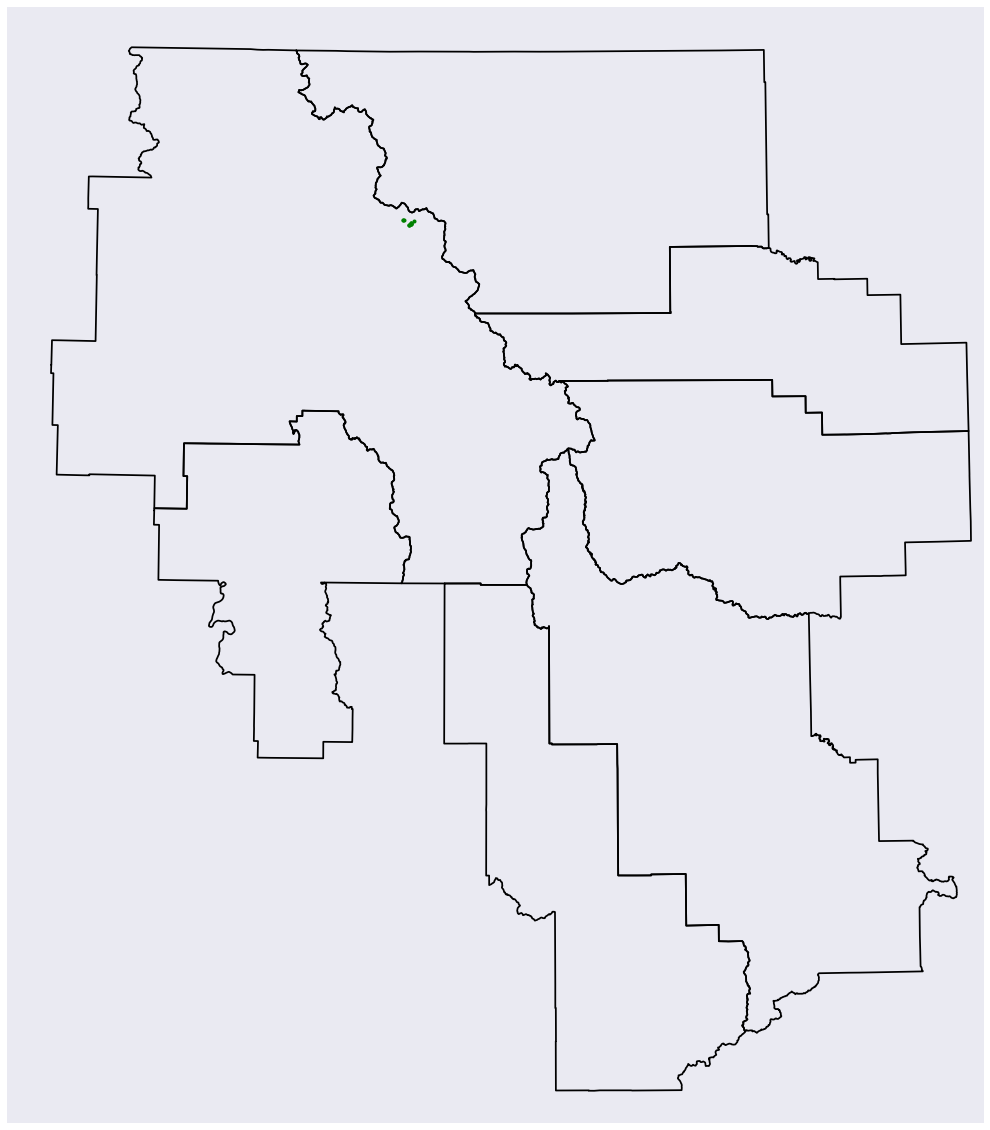

Date: 2015-08-10
--------------------------------------------------
0
0.0
list index out of range


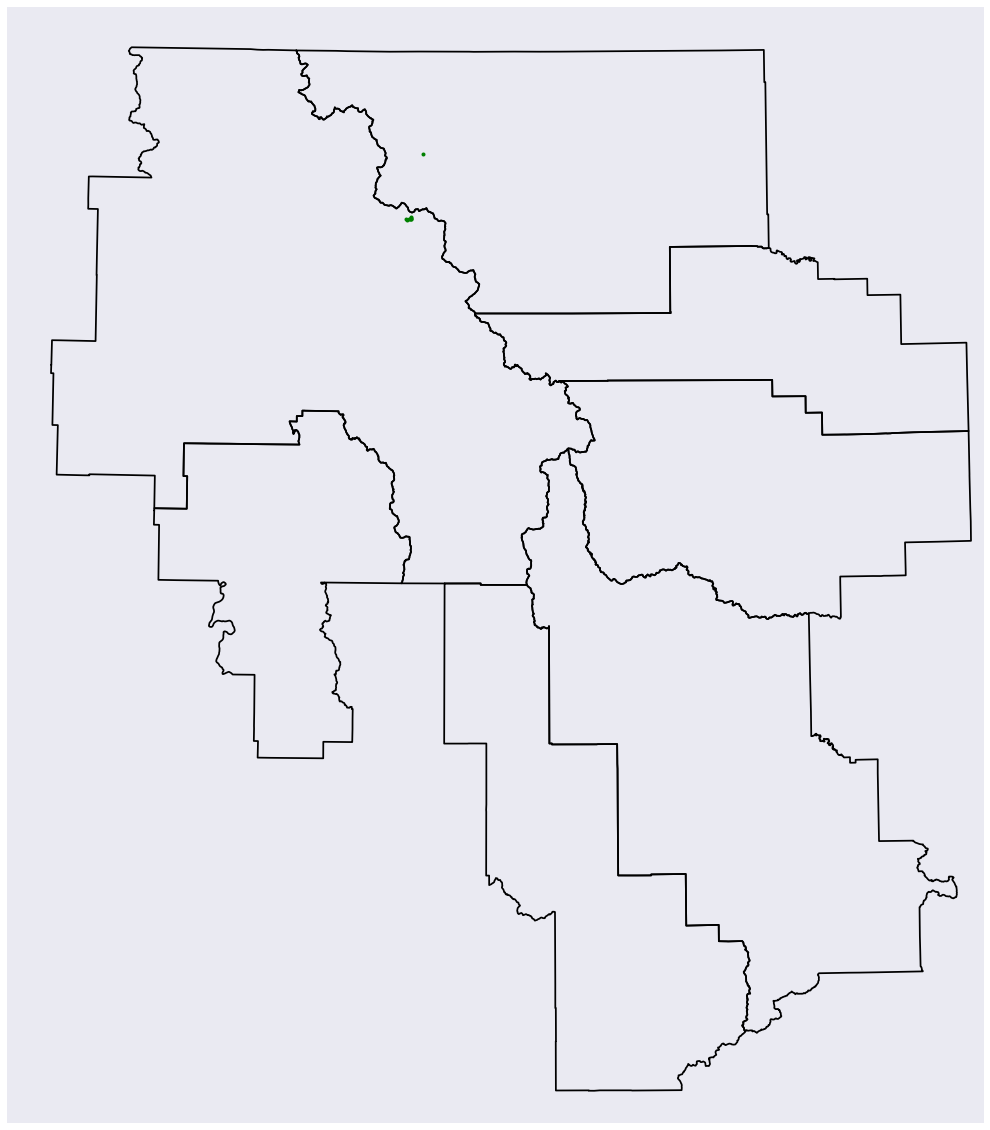

Date: 2015-08-11
--------------------------------------------------
0
0.761061946903


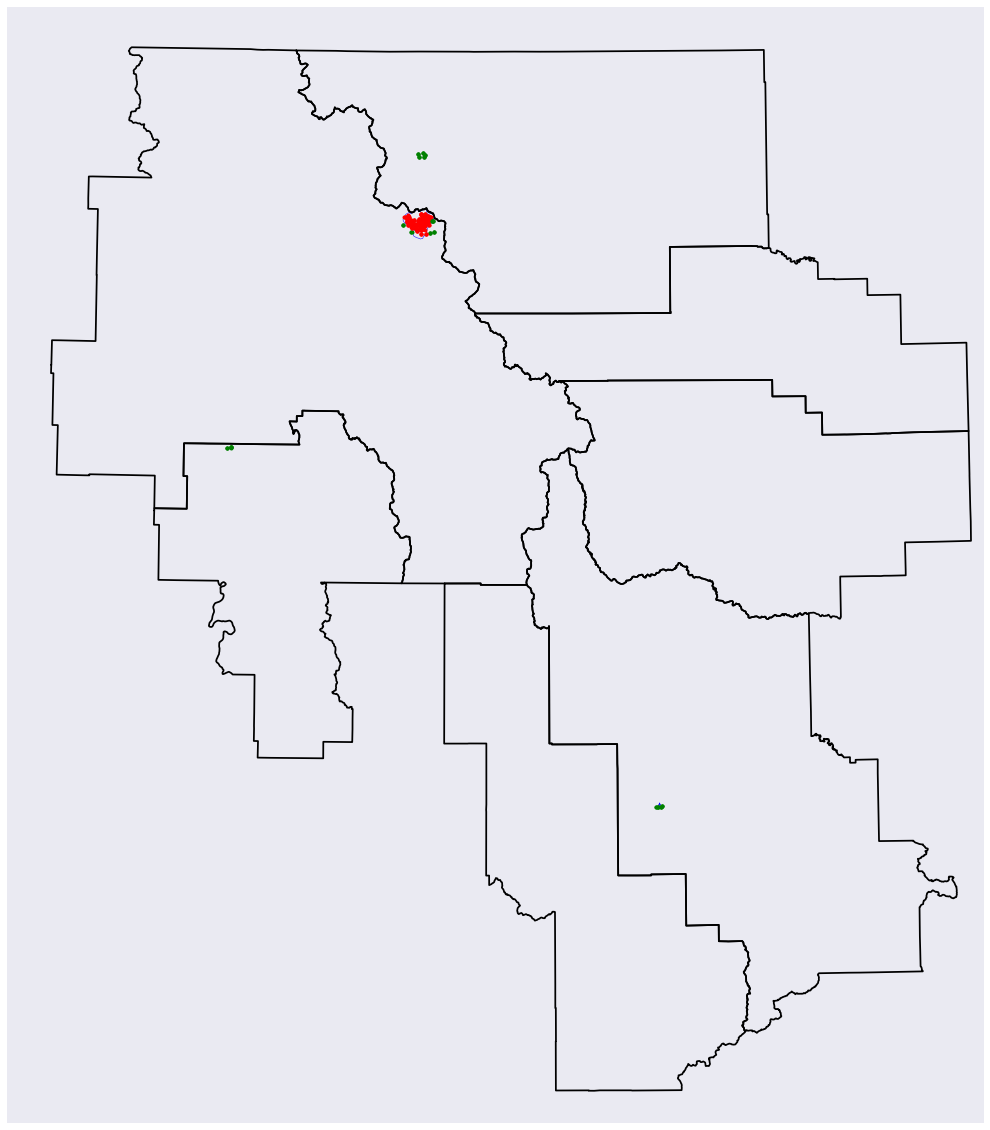

Date: 2015-08-12
--------------------------------------------------
0
0.660377358491


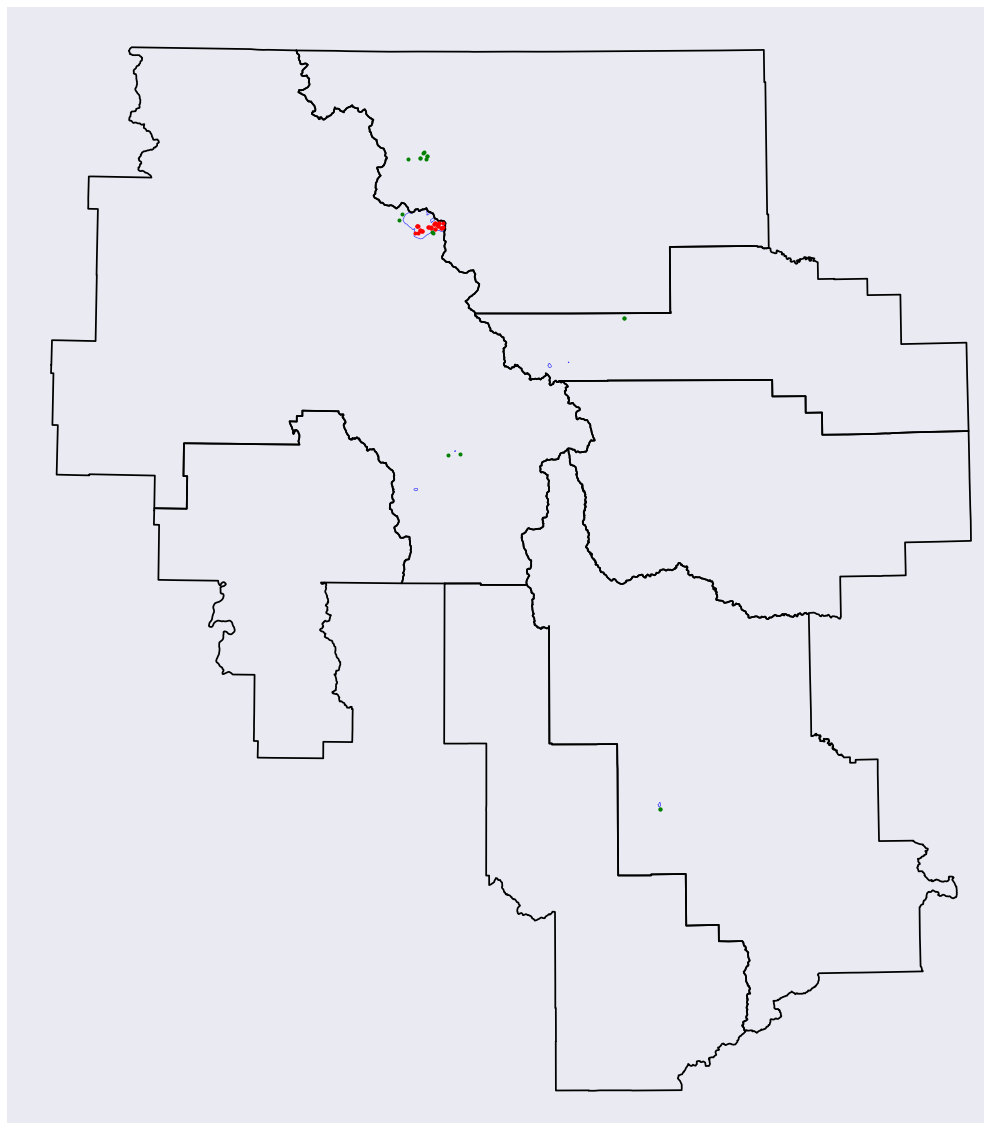

Date: 2015-08-13
--------------------------------------------------
0
0.180952380952


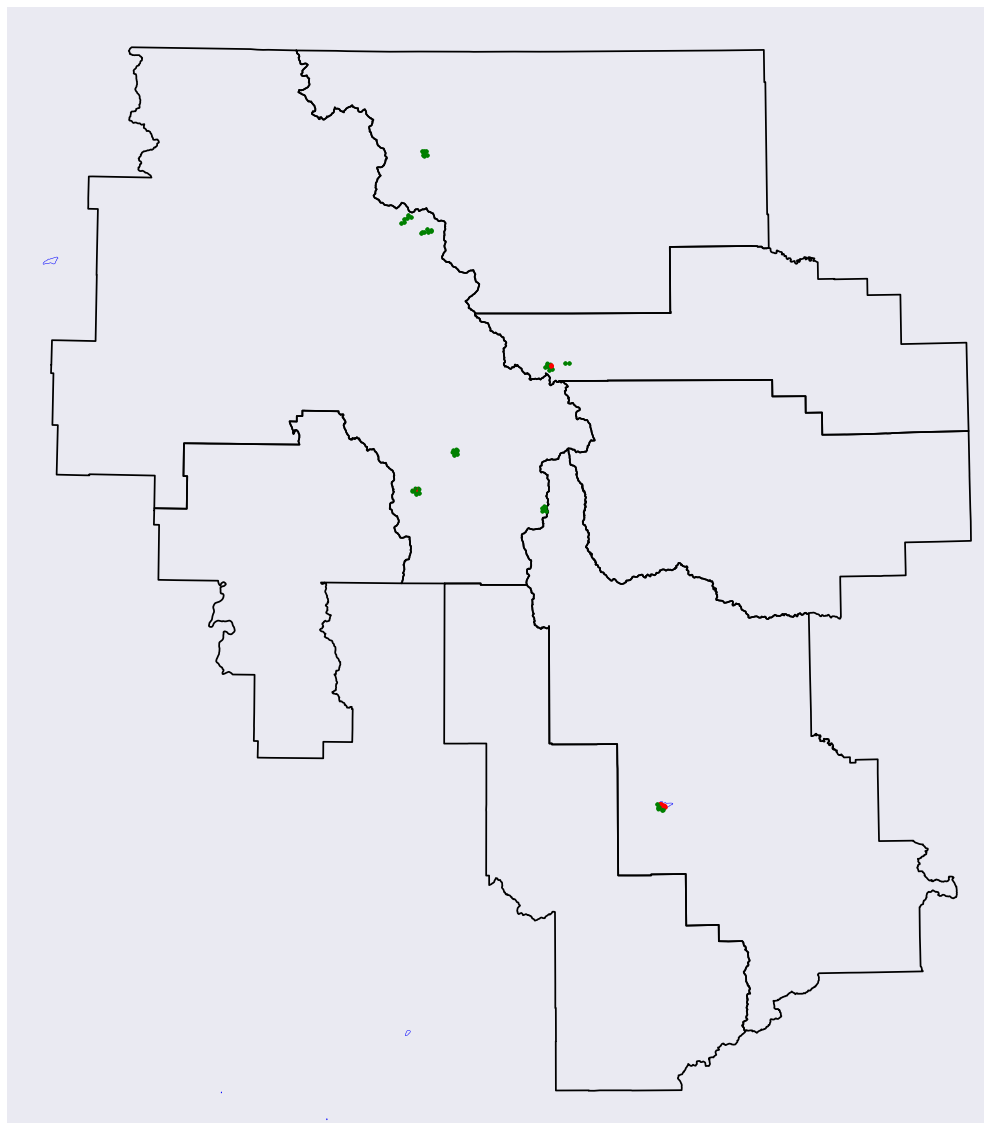

Date: 2015-08-14
--------------------------------------------------
0
0.530864197531


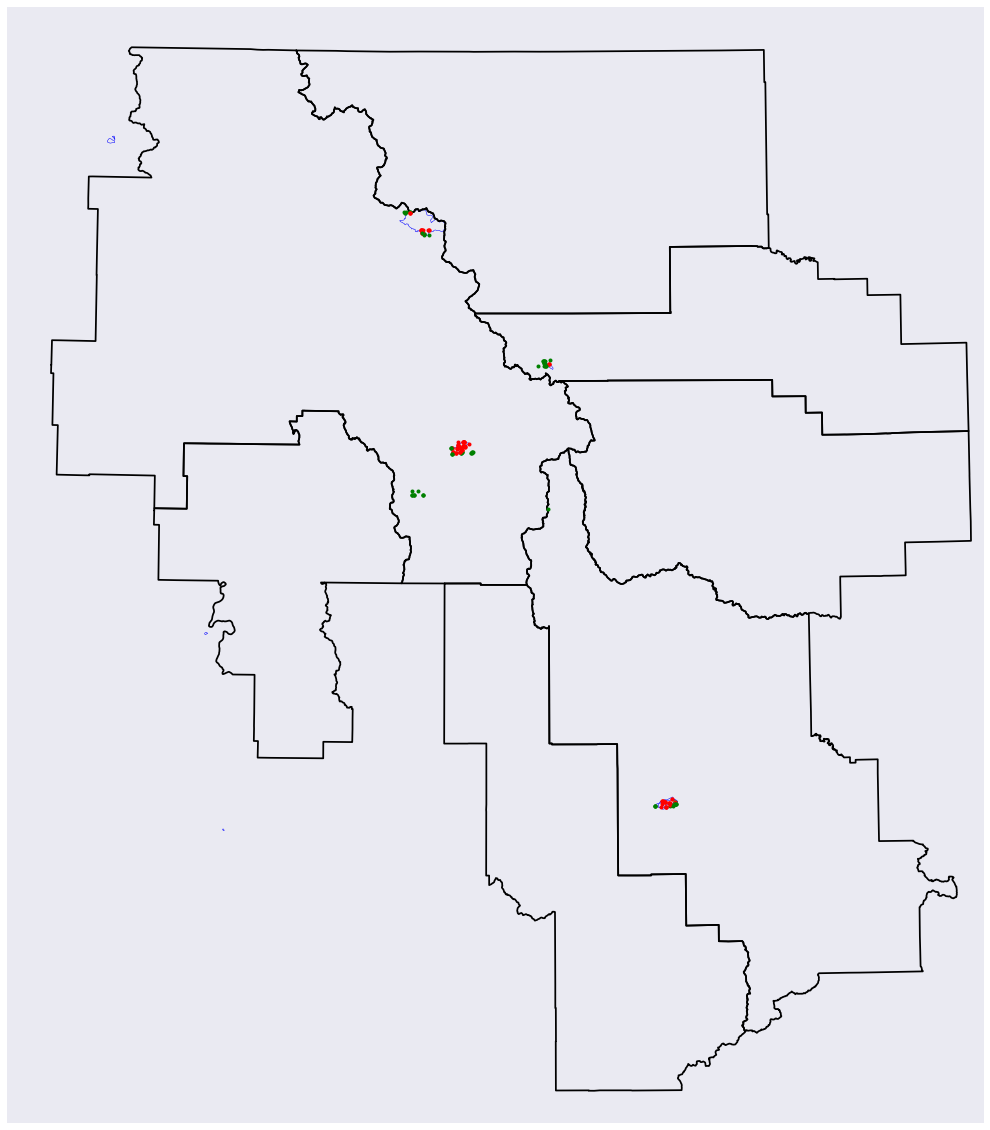

Date: 2015-08-15
--------------------------------------------------
0
0.421052631579


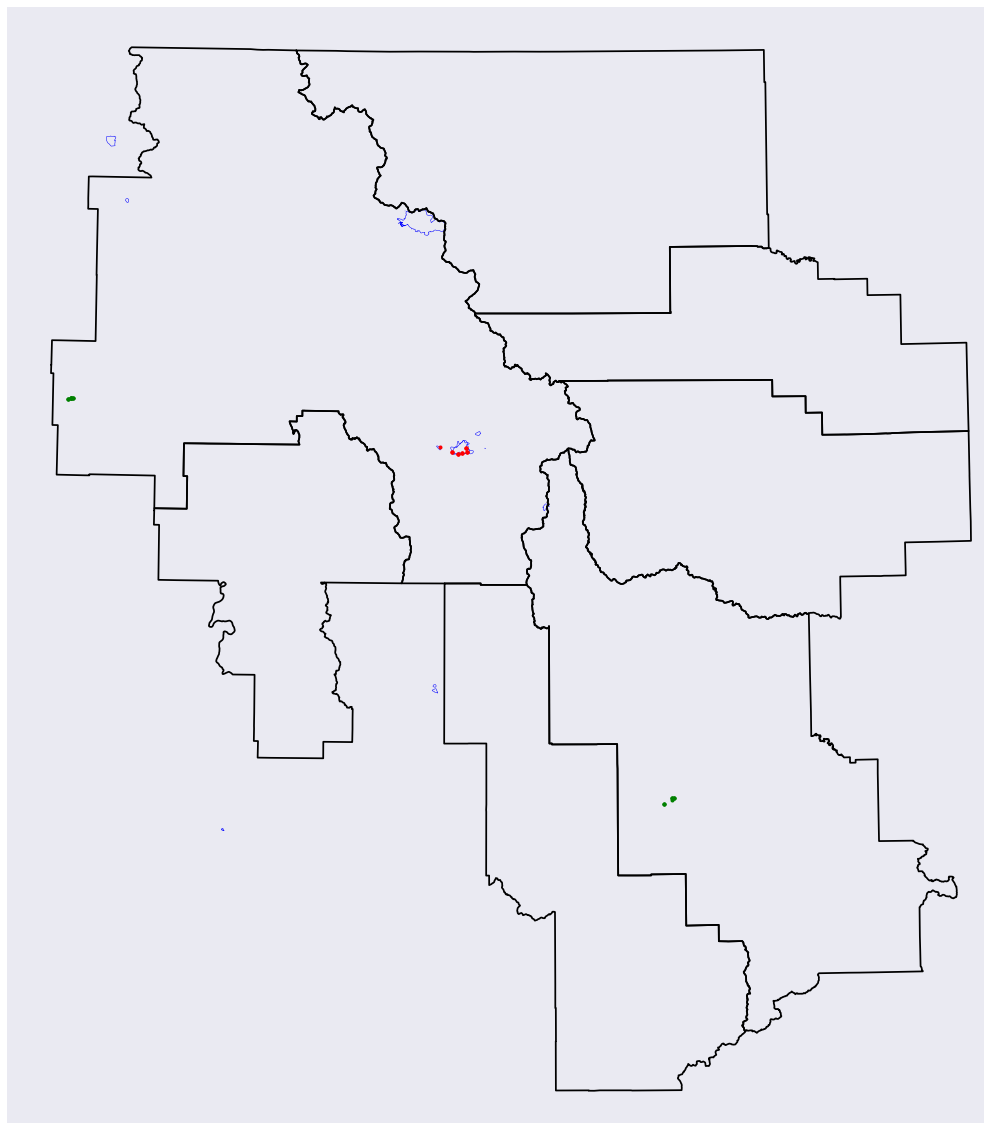

In [10]:
for dt in xrange(9, 16): 
    dt = '2015-08-0' + str(dt) if dt < 10 else '2015-08-' + str(dt)
    print 'Date: {}'.format(dt)
    print '-' * 50
    plot_county_dt('Montana', 'mt', '30', ['Glacier', 'Flathead', 'Pondera', 'Teton', 'Lewis and Clark', 'Lake', 'Powell'], dt)

2015-08-9
Days Ahead: 0
--------------------------------------------------
0
0.0
list index out of range


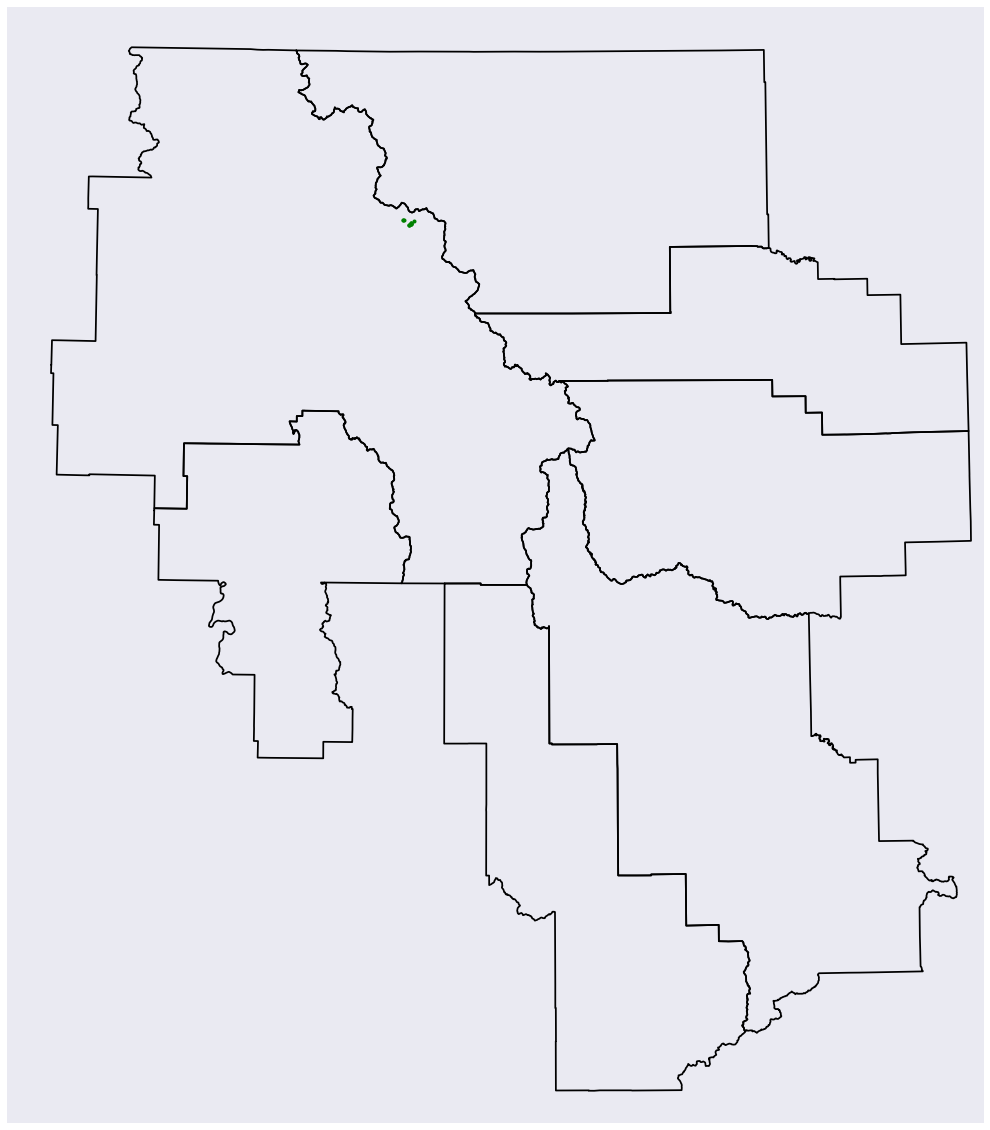

2015-08-10
Days Ahead: 1
--------------------------------------------------
1
0.0
list index out of range


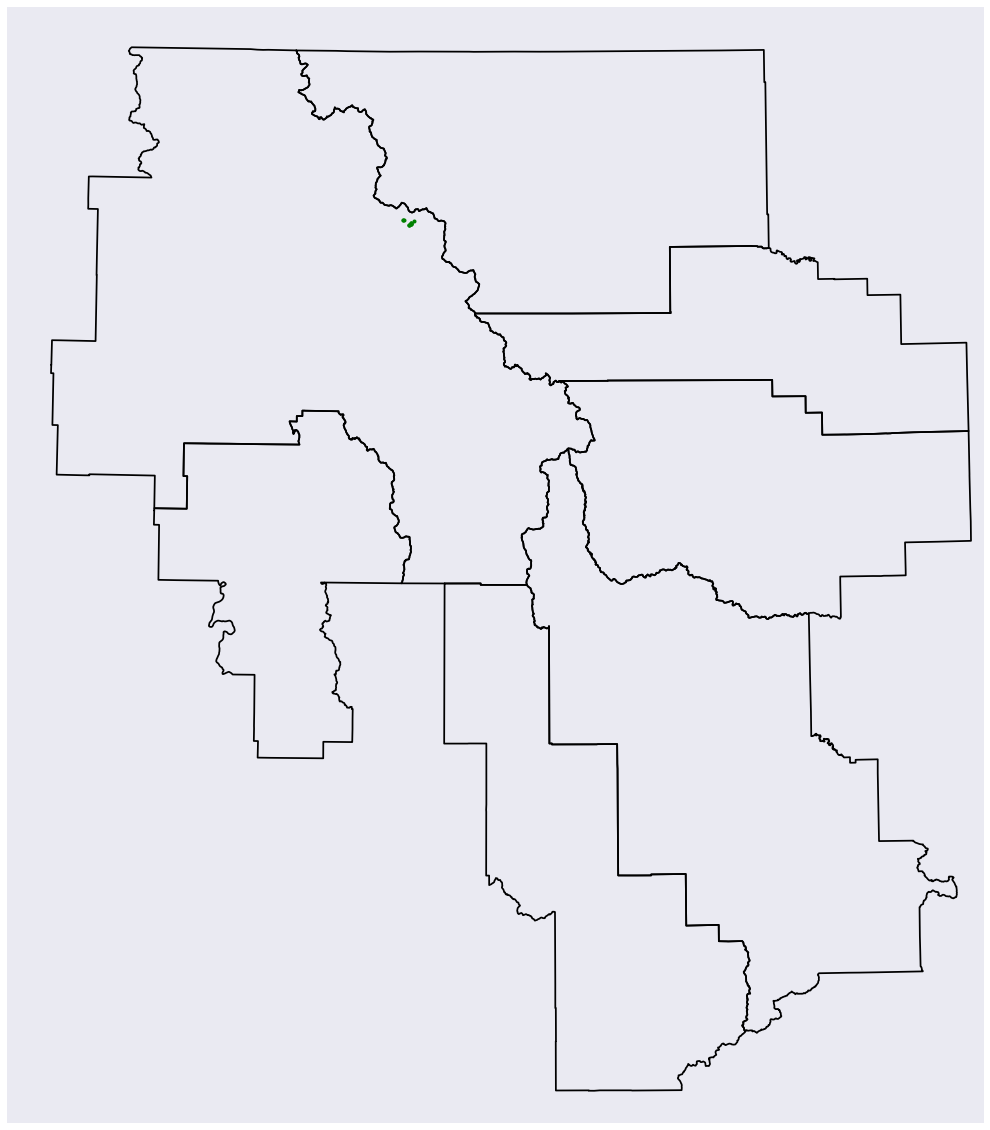

2015-08-12
Days Ahead: 3
--------------------------------------------------
3
0.0


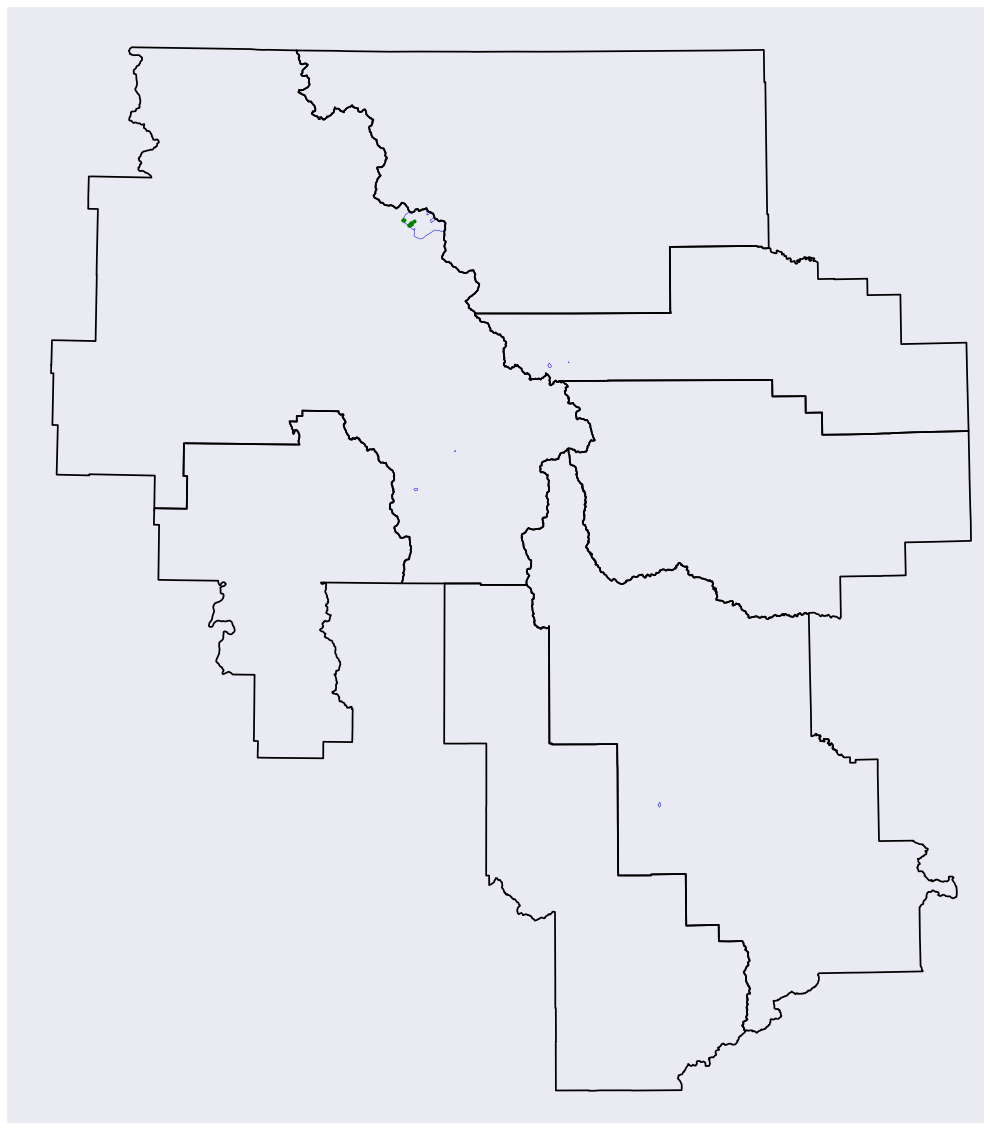

2015-08-14
Days Ahead: 5
--------------------------------------------------
5
0.0


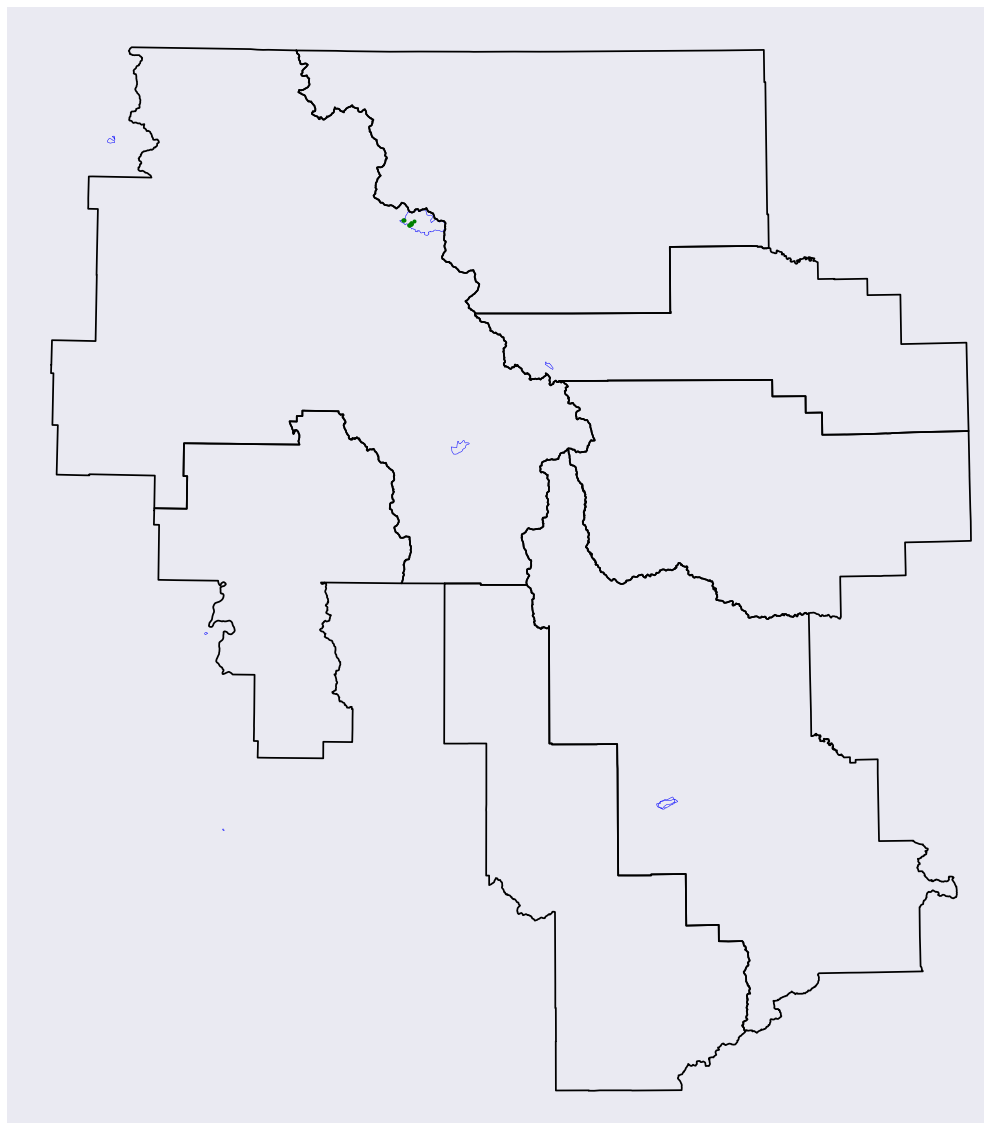

2015-08-16
Days Ahead: 7
--------------------------------------------------
7
0.0


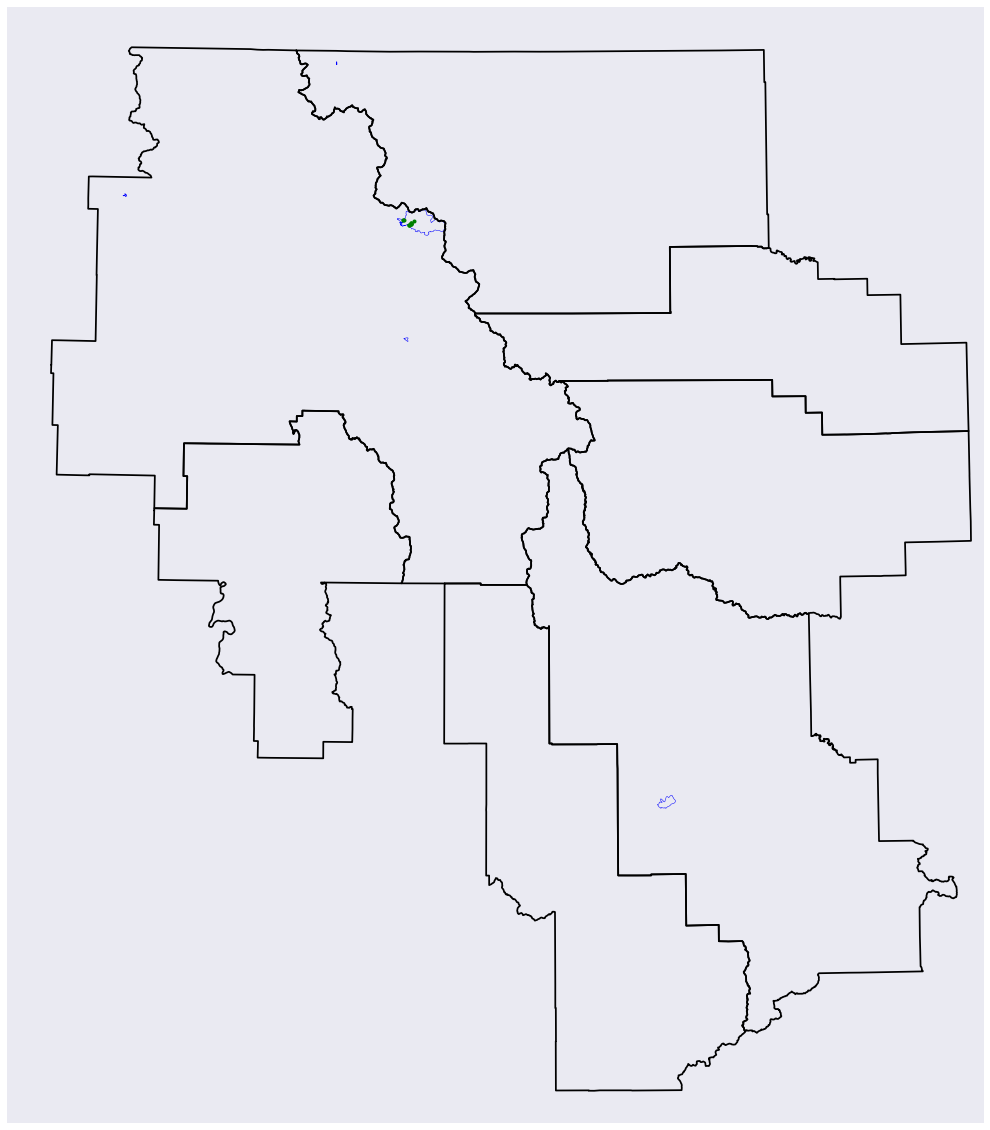

In [19]:
for days_ahead in (0, 1, 3, 5, 7): 
    add = str(days_ahead + 9)
    dt = '2015-08-' + str(add) 
    print dt
    print 'Days Ahead: {}'.format(days_ahead)
    print '-' * 50
    plot_county_dt('Montana', 'mt', '30', ['Glacier', 'Flathead', 'Pondera', 'Teton', 'Lewis and Clark', 'Lake', 'Powell'], '2015-08-09', dt, days_ahead=days_ahead)
    plt.clf()